# Correlated lifetimes
Assumption: both lifetimes are Gaussian  
Convention: first dimension is estimated lifetime, second dimension is true lifetime

Plots: lifetime is plotted in a heatmap, 3Dbar plots would also be possible (https://matplotlib.org/stable/gallery/mplot3d/3d_bars.html, https://stackoverflow.com/questions/43100082/how-to-plot-gradient-fill-on-the-3d-bars-in-matplotlib, https://stackoverflow.com/questions/8437788/how-to-correctly-generate-a-3d-histogram-using-numpy-or-matplotlib-built-in-func/51624315#51624315)

In [1]:
import numpy as np
import csv
import pickle as pkl
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import matplotlib as mpl

In [3]:
# define a function that returns a truncated normal lifetime for given mean, stddev and max. lifetime (min. lifetime is 0)
def univar_normal_trunc(mu, sig, N):
    p = np.zeros(N)
    for n in range(N):
        x = n + 1
        # truncation
        # - beginning
        if x == 1:
             x_prev = min(0, mu - 10*sig)
        else:
            x_prev = n
        # - end
        if x == N:
            x = mu + 10*sig
        # compute probability                
        p[n] = norm.cdf(x, loc = mu, scale = sig) - norm.cdf(x_prev, loc = mu, scale = sig)
    return p
# define a function that returns a truncated bivariate normal lifetime for given means, stddevs, max. lifetimes (min. lifetime is 0), and correlation
def bivar_normal_trunc(mu, sig, N, corr):
    cov = [[sig[0]**2, corr*sig[0]*sig[1]], [corr*sig[0]*sig[1], sig[1]**2]]
    p = np.zeros((N[0], N[1]))
    for i in range(N[0]):
        for j in range(N[1]):
            x, y = [i+1, j+1]
            # truncation
            # - beginning
            if x == 1:
                x_prev = min(0, mu[0] - 10*sig[0])
            else:
                x_prev = i
            if y == 1:
                y_prev = min(0, mu[1] - 10*sig[1])
            else:
                y_prev = j
            # - end
            if x == N[0]:
                x = mu[0] + 10*sig[0]
            if y == N[1]:
                y = mu[1] + 10*sig[1]
            # compute probability                
            p[i,j] = multivariate_normal.cdf([x,y], mean = mu, cov = cov) \
                        - multivariate_normal.cdf([x, y_prev], mean = mu, cov = cov) \
                        - multivariate_normal.cdf([x_prev, y], mean = mu, cov = cov) \
                        + multivariate_normal.cdf([x_prev,y_prev], mean = mu, cov = cov)
    return p
# define a function that returns the reuse factor and the true lifetime of second-life batteries given:
# means, stddevs, max. lifetimes (min. lifetime is zero), correlation, and reuse threshold (i.e., the min. lifetime of reused batteries)
# ! min. lifetime must be an integer !
def reuse_life(mu, sig, N, corr, min_life):
    # compute bivariate lifetime
    p = bivar_normal_trunc(mu, sig, N, corr)
    # apply reuse threshold: reuse only batteries that we think last longer than the threshold
    p[:min_life,:] = 0
    reuse_factor = p.sum()
    # compute and normalize marginals
    pm_est = p.sum(axis = 1) / reuse_factor
    pm_true = p.sum(axis = 0) / reuse_factor
    return {'reuse_factor': reuse_factor, 'p': pm_true}

In [4]:
# Calculate the lifetimes
# - new batteries
EVs = univar_normal_trunc(12, 3, 25)
New = univar_normal_trunc(19, 4, 30)
# - second-life batteries: these are dictionaries with the fields 'reuse_factor' and 'p'
SLB = reuse_life([4, 4], [2, 2], [15, 15], corr = 0.7, min_life = 4)
SLB_LFP = reuse_life([5, 5], [2.5, 2.5], [15, 15], corr = 0.7, min_life = 4)
# - auxiliary function: bivariate lifetime distribution
# p = bivar_normal_trunc([4, 4], [2, 2], [10, 10], corr = 0.5)

The reuse factor is 0.5 for general SLBs and 0.66 for LFP SLBs.


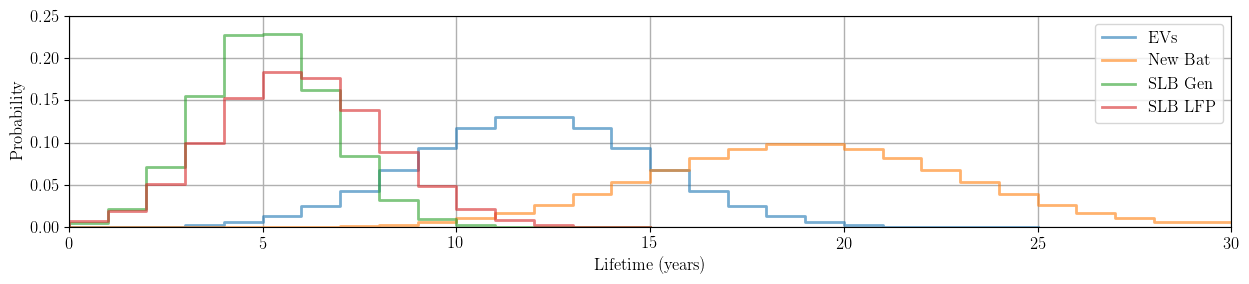

In [17]:
# Print the reuse factors and plot the lifetimes
print('The reuse factor is '+str(round(SLB['reuse_factor'], 2))+' for general SLBs and '+str(round(SLB_LFP['reuse_factor'], 2))+' for LFP SLBs.')
# layout
mpl.rc_file_defaults() # get rid of seaborn effects
transp = 0.6
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{eurosym}')
fig = plt.figure(figsize=[15, 2.75])
plt.rcParams.update({'font.size': 12})
# plot
plt.step(np.arange(len(EVs)+1), np.concatenate([[0], EVs]), label = 'EVs', where = 'pre', alpha = transp, linewidth = 2)
plt.step(np.arange(len(New)+1), np.concatenate([[0], New]), label = 'New Bat', where = 'pre', alpha = transp, linewidth = 2)
plt.step(np.arange(len(SLB['p'])+1), np.concatenate([[0], SLB['p']]), label = 'SLB Gen', where = 'pre', alpha = transp, linewidth = 2)
plt.step(np.arange(len(SLB_LFP['p'])+1), np.concatenate([[0], SLB_LFP['p']]), label = 'SLB LFP', where = 'pre', alpha = transp, linewidth = 2)
# layout
plt.xlim(0,30)
plt.ylim(0, 0.25)
# plt.xticks(np.arange(1+max(N_x, N_y)))
plt.grid(linewidth=1)
plt.xlabel('Lifetime (years)')
plt.ylabel('Probability')
plt.legend(frameon=True)
fig.savefig('pics/lifetimes.pdf',bbox_inches='tight')
fig.savefig('pics/lifetimes.png',bbox_inches='tight')

In [8]:
# export lifetimes and reuse factors
lifetimes_reuse = {'EVs': EVs, 'New': New, 'SLB': SLB['p'], 'SLB_LFP': SLB_LFP['p'], 'SLB_reuse': SLB['reuse_factor'], 'SLB_LFP_reuse': SLB_LFP['reuse_factor']}
# add trailing zeros up to:
N = 101
# len(np.pad(EVs, (0, N - len(EVs)), 'constant')) # - sanity check
for key in ['EVs', 'New', 'SLB', 'SLB_LFP']:
    lifetimes_reuse[key] = np.pad(lifetimes_reuse[key], (0, N - len(lifetimes_reuse[key])), 'constant')

In [12]:
# - to csv
# -- open file for writing, "w" is writing
with open('lifetimes_reuse.csv', 'w') as outfile:
    w = csv.writer(outfile)
    # loop over dictionary keys and values
    for key, val in lifetimes_reuse.items():
        # write every key and value to file
        w.writerow([key, val])
# - to pickle
# -- create a binary pickle file 
f = open("lifetimes_reuse.pkl","wb")
# -- write the python object (dict) to pickle file
pkl.dump(lifetimes_reuse,f)
# -- close file
f.close()

In [ ]:
# to read the file from pkl
infile = open('lifetimes_reuse.pkl','rb')
lifetimes_reuse = pkl.load(infile)
infile.close()

## Code Development

In [24]:
# max. lifetime
N_x, N_y = [10, 10]
# mean lifetime
mu_x, mu_y = [4, 4]
# standard deviation and correlation
sig_x, sig_y, corr = [2, 2, 0.5]

In [25]:
cov = [[sig_x**2, corr*sig_x*sig_y], [corr*sig_x*sig_y, sig_y**2]]

In [31]:
p = np.zeros((N_x, N_y))
for i in range(N_x):
    for j in range(N_y):
        x, y = [i+1, j+1]
        # truncation
        # - beginning
        if x == 1:
            x_prev = min(0, mu_x - 10*sig_x)
        else:
            x_prev = i
        if y == 1:
            y_prev = min(0, mu_y - 10*sig_y)
        else:
            y_prev = j
        # - end
        if x == N_x:
            x = mu_x + 10*sig_x
        if y == N_y:
            y = mu_y + 10*sig_y
        # compute probability                
        p[i,j] = multivariate_normal.cdf([x,y], mean = [mu_x, mu_y], cov = cov) \
                    - multivariate_normal.cdf([x, y_prev], mean = [mu_x, mu_y], cov = cov) \
                    - multivariate_normal.cdf([x_prev, y], mean = [mu_x, mu_y], cov = cov) \
                    + multivariate_normal.cdf([x_prev,y_prev], mean = [mu_x, mu_y], cov = cov)

In [38]:
np.round(np.sqrt(p.size))

20.0

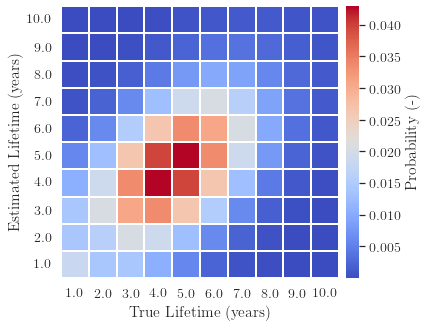

In [41]:
N_x = np.round(np.sqrt(p.size))
N_y = np.round(np.sqrt(p.size))
# plot: sns inverts x and y axis
plt.rc('text', usetex=True)
sns.set(context = "notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'font.family':'serif', 'font.serif':['Computer Modern Roman'], 'text.usetex':True})
fig = plt.figure(figsize = (6, 5))
ax = sns.heatmap(p, xticklabels= 1 + np.arange(N_y), yticklabels= 1+np.arange(N_x),cmap=sns.color_palette("coolwarm",300),\
                 cbar_kws={'label': 'Probability (-)', 'pad':0.02}, linewidths=1, fmt='.3g')
plt.yticks(rotation=0)
plt.xlabel('True Lifetime (years)')
plt.ylabel('Estimated Lifetime (years)')
# plt.title('2019')
ax.invert_yaxis()
# ax.set_ylim(0,6)
# fig.savefig('pics/life_corr.pdf',bbox_inches='tight')

## Decision: only reuse batteries with an estimated lifetime higher than $\ell_\min$

In [27]:
# reuse threshold
l_min = 4
p_reuse = p
p_reuse[:l_min,:] = np.nan

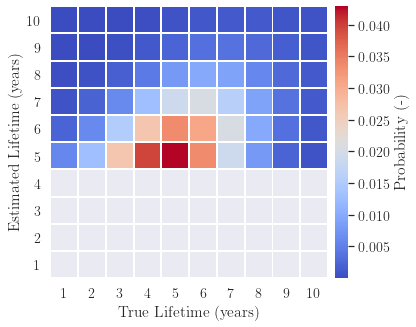

In [29]:
# plot: sns inverts x and y axis
plt.rc('text', usetex=True)
sns.set(context = "notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'font.family':'serif', 'font.serif':['Computer Modern Roman'], 'text.usetex':True})
fig = plt.figure(figsize = (6, 5))
ax = sns.heatmap(p_reuse, yticklabels= 1 + np.arange(N_x),xticklabels= 1+np.arange(N_y),cmap=sns.color_palette("coolwarm",300),\
                 cbar_kws={'label': 'Probability (-)', 'pad':0.02}, linewidths=1, fmt='.3g')
plt.yticks(rotation=0)
plt.xlabel('True Lifetime (years)')
plt.ylabel('Estimated Lifetime (years)')
# plt.title('2019')
ax.invert_yaxis()
# ax.set_ylim(0,6)
fig.savefig('pics/life_corr_cut.pdf',bbox_inches='tight')

### Compute reuse factor and plot marginal distributions

In [23]:
p_reuse[:l_min,:] = 0
reuse_factor = p_reuse.sum()
print('The reuse factor is: '+str(round(reuse_factor, 2)))
# compute and normalize marginals
pm_est = p_reuse.sum(axis = 1) / reuse_factor
pm_true = p_reuse.sum(axis = 0) / reuse_factor

The reuse factor is: 0.5


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


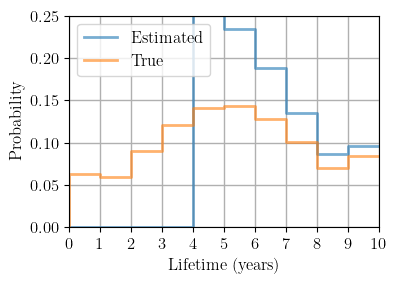

In [30]:
# layout
mpl.rc_file_defaults() # get rid of seaborn effects
transp = 0.6
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{eurosym}')
fig = plt.figure(figsize=[4, 2.75])
plt.rcParams.update({'font.size': 12})
# plot
plt.step(np.arange(N_x+1), np.concatenate([[0], pm_est]), label = 'Estimated', where = 'pre', alpha = transp, linewidth = 2)
plt.step(np.arange(N_y+1), np.concatenate([[0], pm_true]), label = 'True', where ='pre', alpha = transp, linewidth = 2)
# layout
plt.xlim(0,max(N_x, N_y))
plt.ylim(0, 0.25)
plt.xticks(np.arange(1+max(N_x, N_y)))
plt.grid(linewidth=1)
plt.xlabel('Lifetime (years)')
plt.ylabel('Probability')
plt.legend(frameon=True)
fig.savefig('pics/p_est_true.pdf',bbox_inches='tight')